<a href="https://colab.research.google.com/github/gowrithampi/deeplearning_with_pytorch/blob/main/Chapter_5_The_mechanics_of_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with Pytorch
## Chapter 5: The Mechanics of Learning

### This is based entirely on the Text Book: 
### Deep Learning with PyTorch by 
* Eli Stevens
* Luca Antiga
* Thomas Viehmann

I added my own mini experiments, insights, an eye into my struggles and my understanding of the text as I move through it. However phrases, sentences from the author may creep in. I don't claim this to be adding significantly to their work, neither do I seek to gain monetary compensation from this effort.  
The original code in the textbook is available here:

https://github.com/deep-learning-with-pytorch/dlwpt-code

This is a fun chapter it familiarizes one with the idea of learning, by building a simple linear regression model by gradient descent. 

Problem statement : There is a cool thermometer hanging on the wall. It seems to measure temperature, but we don't know what unit it measures temperature in. We want a way to convert the temperature shown by the thermometer to celsius. 


Our strategy: We observe a set of temperature data, from our little pocket celsius thermometer and the corresponding reading from the wall thermometer. Armed with this data, we tackle this problem as a machine learning problem.
Assuming there is a linear relationship between the readings from both thermometers, we use gradient descent to learn the weights of our model. 
First without pytorch's autograd and then with it. 

In [1]:
# t_c is a list of temperatures observed in celsius
# t_u is a list of temperatures observed in unknown units 
import torch
t_c = [0.5, 14.0, 15.0,28.0,11.0,8.0,3.0,-4.0,6.0,13.0,21.0]
t_u = [35.7,55.9,58.2,81.9,56.3,48.9,33.9,21.8,48.4,60.4,68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)


Let's visualize above data

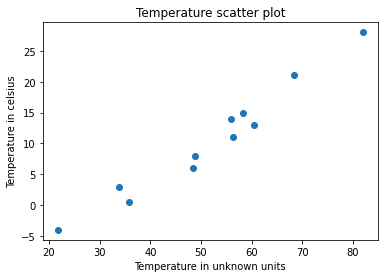

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.scatter(t_u, t_c)
plt.title('Temperature scatter plot')
ax.set_xlabel('Temperature in unknown units')
ax.set_ylabel('Temperature in celsius')
plt.show()

In [3]:
## linear model 
def model (t_u, w , b):
  # predicted temperature is 
  # weight times unknown temp
  # plus bias 
  # w and b are scalars
  # their values get broadcasted
  # across the vector v_u
  t_p = w*t_u +b 
  return t_p

Now we need a loss function. A loss function is a function of the model parameters, that needs to decrease as learning progresses. This is how we know that we are learning (updating the model parameters) in the right direction. 

If the loss function is convex, then it will have a global minimum, and the argmin of the loss function will be the final value of the model parameters. 

Here we use the mean squared error between t_c (the observed temperature in celsius) and t_p(the temperature predicted by our model) as the loss function. 


In [4]:
def loss_function (t_c, t_p):

  squared_error = (t_c - t_p)**2
  mean_squared_error = squared_error.mean()
  return mean_squared_error



In [5]:
# initialize weights and bias
w = torch.ones([])
b = torch.zeros([])

# model forward pass
t_p = w*t_u +b

# calculate loss
loss = loss_function(t_c, t_p)

print(loss)

tensor(1763.8848)


Gradient Descent: The basic idea is that we can find the minimum of the loss function by taking baby steps in the direction in which the function is decreasing. Of course in the case of the above convex function, it is easy to find the global minimum by differentiating the function and equating it to zero. In the interest of learning (our learning, not the model's) though, we'll try to get there by gradient descent. 

In [6]:
# derivative of loss function with respect to t_p (model)
def dloss_fn(t_c, t_p):
  dloss_dtp = 2 * (t_p - t_c)/t_p.size(0)
  return dloss_dtp

# derivative of t_p(model) with respect to w
def dmodel_dw(t_u, w, b):
  return t_u 

# derivative of t_p(model) with respect to b
def dmodel_db(t_u, w, b): 
   return 1.0 

# final gradient depends on input, actuals, prediction and model parameters
# final gradient is calculated by using the chain rule and the above gradients
def gradient(t_u, t_c, t_p, w, b):
    dloss_dw = dloss_fn(t_c, t_p)* dmodel_dw(t_u, w , b)
    dloss_db = dloss_fn(t_c, t_p)*dmodel_db(t_u, w, b)
    return dloss_dw.sum(), dloss_db.sum()


The training loop will now consist of iterating through 
1) A forward pass
2) evaluation of gradients at the weights used in the forward pass
3) updating the weights using the learning rate and gradients (backward pass)

In [7]:
# training loop also depends on number of epochs and the learning rate
def training_loop (n_epochs, learning_rate, t_u, t_c, t_p, params): 
  w,b = params
  for epoch in range(1, n_epochs): 
    grad_w , grad_b = gradient(t_u, t_c, t_p , w, b) 
    w = w - learning_rate*grad_w
    b = b - learning_rate*grad_b
    t_p = model(t_u, w,b)
    loss = loss_function(t_c, t_p)
    if (epoch % 50 == 0): 
     print("Epoch number {0:.0f} , Loss is {1:.2f}".format(epoch,loss))
     print("Bias is {bias:0.4f} and Weight is {weight: 0.4f} \n\n".format( bias = b,weight = w))

  return w, b


In [8]:
# initialize weights and bias
w = torch.ones([])
b = torch.zeros([])
training_loop(100, 0.0001, t_u, t_c, t_p , (w,b))

Epoch number 50 , Loss is 29.07
Bias is -0.0287 and Weight is  0.2325 




(tensor(0.2327), tensor(-0.0435))

### Normalization of inputs: 
In the first few epochs we can notice that there is an order of magnitude difference between the weight and the bias term.
To have a learning rate that works for both the weight and the bias, it is important to normalize these inputs. 

In the textbook, the authors use a simple rescaling factor of 0.1 for the input t_u. Let's try that.



In [9]:
w = torch.ones([])
b = torch.zeros([])

w,b = training_loop(5000,  1e-2, t_u*0.1, t_c, t_p, params = (w,b))

Epoch number 50 , Loss is 25.64
Bias is -1.2016 and Weight is  2.5231 


Epoch number 100 , Loss is 22.09
Bias is -2.5140 and Weight is  2.7549 


Epoch number 150 , Loss is 19.09
Bias is -3.7194 and Weight is  2.9678 


Epoch number 200 , Loss is 16.57
Bias is -4.8266 and Weight is  3.1634 


Epoch number 250 , Loss is 14.43
Bias is -5.8435 and Weight is  3.3431 


Epoch number 300 , Loss is 12.63
Bias is -6.7776 and Weight is  3.5081 


Epoch number 350 , Loss is 11.12
Bias is -7.6355 and Weight is  3.6596 


Epoch number 400 , Loss is 9.84
Bias is -8.4235 and Weight is  3.7988 


Epoch number 450 , Loss is 8.76
Bias is -9.1473 and Weight is  3.9267 


Epoch number 500 , Loss is 7.84
Bias is -9.8121 and Weight is  4.0441 


Epoch number 550 , Loss is 7.08
Bias is -10.4228 and Weight is  4.1520 


Epoch number 600 , Loss is 6.43
Bias is -10.9836 and Weight is  4.2511 


Epoch number 650 , Loss is 5.88
Bias is -11.4988 and Weight is  4.3421 


Epoch number 700 , Loss is 5.42
Bias is -1

With normalization it was possible to use a larger learning rate of 0.2 and not have the parameters explode. Setting n_epochs to 5000, we can see that the values closely resemble the parameters for converting Fahrenheit to Celsius. 
The actual values are (w = 5.5556, b = -17.7778). Looks like the fancy wall thermometer was showing the temperature in Fahrenheit

Revisualizing the data using matplotlib

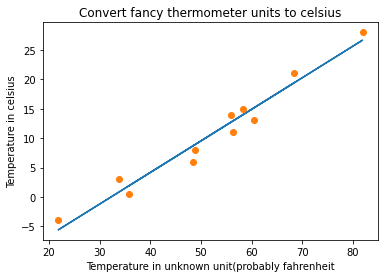

tensor([ 1.8593, 12.7008, 13.9352, 26.6552, 12.9155,  8.9439,  0.8932, -5.6009,
         8.6755, 15.1160, 19.4097])
tensor(5.3671) tensor(-17.3012)
tensor([174.3037, 282.7188, 295.0630, 422.2629, 284.8656, 245.1492, 164.6429,
         99.7012, 242.4656, 306.8706, 349.8073])


In [10]:
# we scale the input because the model in normalized
t_p = model(t_u*0.1, w, b)

plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.title("Convert fancy thermometer units to celsius")
plt.xlabel('Temperature in unknown unit(probably fahrenheit')
plt.ylabel('Temperature in celsius')
plt.show()
print(t_p)
print(w, b)
print(t_u*w + b)

Pytorch and automatic differentiation.
Gradients in pytorch can be calculated via automatic differentiation, instead of manually defining formulae for them. 
The textbook reworks the above example using automatic differentiation. 
I will first take a break from this problem to explore automatic differentiation with tensors. We will then get back to the above problem and solve it using automatic differentiation. 

We can keep the product rule and chain rule of differntiation in mind for checking pytorch's answer

In [11]:
## create a tensor
# The parameter requires_grad needs to be set to True, for gradients to accumulate. 
original = torch.tensor([1,2,3], dtype = torch.float64, requires_grad = True)
operand1 = torch.tensor([3,2,1], dtype = torch.float64, requires_grad = True)
operand2 = torch.tensor([4,5,6], dtype = torch.float64, requires_grad = True )

## the backward pass only works for scalars, so we have created a scalar dor product here
dot_product1 = original.dot(operand1)
dot_product2 = original.dot(operand2)

print(dot_product1, dot_product2)

tensor(10., dtype=torch.float64, grad_fn=<DotBackward>) tensor(32., dtype=torch.float64, grad_fn=<DotBackward>)


In [12]:
#retain_graph needs to be set to True if we intent to call the backward pass again. 
#Which we may decide to do to learn  
dot_product1.backward(retain_graph = True)
original.grad

tensor([3., 2., 1.], dtype=torch.float64)

In [13]:
# if the gradient of original is not reset to zero,gradients from future calculations
# like the one below will accumulate on top of previous calculations. Comment out 
# the .zero_() function to observe this 
original.grad.zero_()
dot_product2.backward(retain_graph = True)
original.grad

tensor([4., 5., 6.], dtype=torch.float64)

In [14]:
original.grad.zero_()

# change the below from + to * , calculate gradients by hand
# compare with pytorch's answer 

output = dot_product1 *dot_product2
output.backward(retain_graph = True)
original.grad



tensor([136., 114.,  92.], dtype=torch.float64)

Now that I've understood how autograd works. I'm going to try to build the learning model for temperature conversion using autograd

In [15]:
## training function rewritten using autograd

def training_loop_auto(n_epochs, learning_rate, t_u, t_c, params): 

  for epoch in range(0, n_epochs): 
    # zero out the parameter gradients. 
    if params.grad is not None: 
        params.grad.zero_()    
    #w, b = params[0] , params[1]
    t_p = model(t_u, *params )
    
    loss = loss_function(t_c, t_p)
    loss.backward(retain_graph = True)
    # here we are telling pytorch to not include the
    # below computation in the forward graph

    with torch.no_grad():
      if params.grad is not None: 
          # params updated in place      
          params-= learning_rate*params.grad
          

    if (epoch % 500 == 0):
      print("Epoch number {epoch_num:d} has loss {loss_value:0.2f}".format(epoch_num = epoch, loss_value = loss))
      print("Bias is  {bias:0.2f} has weight is {weight:0.2f}\n\n".format(bias = params[0], weight = params[1]))

  return params 

## Important: I learned that params = params- learning_rate*params.grad 
## does not update params in place, a different variable called params is created
## and assigned the value params - learning_rate*params.grad. 
## This variable did not have requires_grad = True
## My code failed and I did not know why for the longest time


In [16]:
training_loop_auto(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0], requires_grad=True), # <1> 
    t_u = t_u*0.1, # <2> 
    t_c = t_c)

Epoch number 0 has loss 80.36
Bias is  1.78 has weight is 0.11


Epoch number 500 has loss 7.84
Bias is  4.05 has weight is -9.83


Epoch number 1000 has loss 3.83
Bias is  4.80 has weight is -14.11


Epoch number 1500 has loss 3.09
Bias is  5.13 has weight is -15.94


Epoch number 2000 has loss 2.96
Bias is  5.26 has weight is -16.72


Epoch number 2500 has loss 2.93
Bias is  5.32 has weight is -17.06


Epoch number 3000 has loss 2.93
Bias is  5.35 has weight is -17.20


Epoch number 3500 has loss 2.93
Bias is  5.36 has weight is -17.26


Epoch number 4000 has loss 2.93
Bias is  5.36 has weight is -17.29


Epoch number 4500 has loss 2.93
Bias is  5.37 has weight is -17.30




tensor([  5.3671, -17.3012], requires_grad=True)

## Optimizers

Pytorch provides a variety of optimizers, so we don't have to implement gradient descent ourselves. These optimizers also have their own strategies to assist with model convergence. 
Let us take a look at some of the available optimizers. 

In [17]:
import torch.optim as optim 
dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'Optimizer',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [18]:
# the optimizer object's constructor takes the model's parameter tensor and the learning rate as its'parameters
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate = 0.01

# sgd stands for stochastic gradient descent. 
# since our batch size in this case is the entire dataset, we aren't using
# this optimizer stochastically 

sgd_optimizer = optim.SGD([params], lr = learning_rate)



In [43]:
#rewriting the training loop

def training_loop_with_optim(n_epochs,t_c, t_u, params, learning_rate, opt):

  for epoch in range(1,n_epochs): 
      t_p = model(t_u, *params) 
      loss = loss_function(t_c, t_p)
      #print(loss, params.grad)
      opt.zero_grad()
      loss.backward()
      opt.step()
     

      if epoch% 500 == 0:
          print('Epoch {epoch_num: d} Loss is {loss_value:0.2f}'.format(epoch_num=epoch, loss_value = loss))
          print('Parameters are {params}'.format(params = params))

  return params
  







In [45]:
params = torch.tensor([1.0,0.0], requires_grad = True)
opt = optim.SGD([params], lr = 0.01)
training_loop_with_optim(5000, t_c, t_u*0.1, params, learning_rate, opt)


Epoch  500 Loss is 7.86
Parameters are tensor([ 4.0443, -9.8133], requires_grad=True)
Epoch  1000 Loss is 3.83
Parameters are tensor([  4.8021, -14.1031], requires_grad=True)
Epoch  1500 Loss is 3.09
Parameters are tensor([  5.1260, -15.9365], requires_grad=True)
Epoch  2000 Loss is 2.96
Parameters are tensor([  5.2644, -16.7200], requires_grad=True)
Epoch  2500 Loss is 2.93
Parameters are tensor([  5.3236, -17.0549], requires_grad=True)
Epoch  3000 Loss is 2.93
Parameters are tensor([  5.3489, -17.1980], requires_grad=True)
Epoch  3500 Loss is 2.93
Parameters are tensor([  5.3597, -17.2591], requires_grad=True)
Epoch  4000 Loss is 2.93
Parameters are tensor([  5.3643, -17.2853], requires_grad=True)
Epoch  4500 Loss is 2.93
Parameters are tensor([  5.3662, -17.2964], requires_grad=True)


tensor([  5.3671, -17.3012], requires_grad=True)

With other optimizers like Adam, which uses an adaptive learning rate, we will not have to scale our inputs. Trying out adam below

In [48]:
# Adam converges way faster and can take a much larger learning rate

params = torch.tensor([1.0,0.0], requires_grad = True)
opt = optim.Adam([params], lr = 0.1)
training_loop_with_optim(1500, t_c, t_u, params, learning_rate, opt)


Epoch  500 Loss is 7.61
Parameters are tensor([  0.4081, -10.0095], requires_grad=True)
Epoch  1000 Loss is 3.09
Parameters are tensor([  0.5131, -15.9629], requires_grad=True)


tensor([  0.5350, -17.2015], requires_grad=True)

### Validation Set

To prevent overfitting the model by minimizing training loss alone, it makes sense to set aside some of the data as a validation set. 
Best lectures I've seen on overfitting are by Professor Yasser Abu Moustafa of Caltech. 
Refer the below link: 
* https://www.youtube.com/watch?v=EQWr3GGCdzw&list=PLD63A284B7615313A&index=11&ab_channel=caltech

I suggest watching all his lectures, he explains generalization and learning better than almost anyone else. 


In [56]:
n_samples = t_u.shape[0]
n_val = int(0.2* n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[0:-n_val]
val_indices = shuffled_indices[-n_val:n_samples]

In [70]:
# I am deviating from the textbook a little here
# I am setting aside a validation sample within the training loop
# because this is ultimately for illustrative purposes
# and I got tired of passing too many arguments 

def training_loop_with_val(n_epochs, t_u, t_c, params, optim): 

  n_samples = t_u.shape[0]
  n_val = int(n_samples * 0.2)
  shuffled_indices = torch.randperm(n_samples)

  train_indices = shuffled_indices[:-n_val]
  val_indices = shuffled_indices[-n_val:n_samples]

  train_t_u = t_u[train_indices]
  val_t_u = t_u[val_indices]
  
  train_t_c = t_c[train_indices]
  val_t_c = t_c[val_indices]

  for epoch in range(1,n_epochs): 
    train_t_p = model(train_t_u, *params)
    val_t_p = model(val_t_u, *params)
    train_loss = loss_function(train_t_c, train_t_p)
    train_loss.backward()
    optim.step()
    optim.zero_grad()

    ## we use torch.no_grad() here to retaining an expensive forward graph
    ## for val_loss which we won't use, ultimately. 
    
    with torch.no_grad():
        val_loss = loss_function(val_t_c, val_t_p)
    
    if(epoch% 500 == 0): 
      print("Epoch {epoch:d} Training loss is {loss_value: 0.2f}".format(epoch = epoch, loss_value = train_loss))
      print("Epoch {epoch:d} Validation loss is {loss_value: 0.2f}".format(epoch = epoch, loss_value = val_loss))

      print("Parameters are {params}".format(params = params))
  return params



In [71]:
from torch import optim 
params = torch.tensor([1.0, 0.0], requires_grad = True)
optim_SGD = optim.SGD([params], lr = 0.01)
training_loop_with_val(5000,t_u*0.1, t_c, params, optim_SGD)

Epoch 500 Training loss is  8.31
Epoch 500 Validation loss is  1.08
Parameters are tensor([  4.1501, -10.5170], requires_grad=True)
Epoch 1000 Training loss is  3.77
Epoch 1000 Validation loss is  1.81
Parameters are tensor([  4.9339, -15.0677], requires_grad=True)
Epoch 1500 Training loss is  2.96
Epoch 1500 Validation loss is  3.20
Parameters are tensor([  5.2660, -16.9956], requires_grad=True)
Epoch 2000 Training loss is  2.81
Epoch 2000 Validation loss is  3.99
Parameters are tensor([  5.4067, -17.8125], requires_grad=True)
Epoch 2500 Training loss is  2.78
Epoch 2500 Validation loss is  4.36
Parameters are tensor([  5.4663, -18.1585], requires_grad=True)
Epoch 3000 Training loss is  2.78
Epoch 3000 Validation loss is  4.52
Parameters are tensor([  5.4915, -18.3051], requires_grad=True)
Epoch 3500 Training loss is  2.78
Epoch 3500 Validation loss is  4.59
Parameters are tensor([  5.5022, -18.3672], requires_grad=True)
Epoch 4000 Training loss is  2.78
Epoch 4000 Validation loss is 

tensor([  5.5095, -18.4094], requires_grad=True)

#### That's it for Chapter 5!   
#### See you in Chapter 6! 
